In [1]:
#bringin in tensorflow
import tensorflow as tf
# most common code written initially for deep learning
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
#bringing in tensorflow datasets for fashion
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [3]:
#use the tensorflow datasets api to bring in the data soource
ds = tfds.load('fashion_mnist', split ='train')

In [4]:
ds.as_numpy_iterator().next()['label']

2

In [5]:
#do some data transformation
import numpy as np 

In [6]:
#setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [7]:
dataiterator = ds.as_numpy_iterator()

In [8]:
#getting data out of the pipeline
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

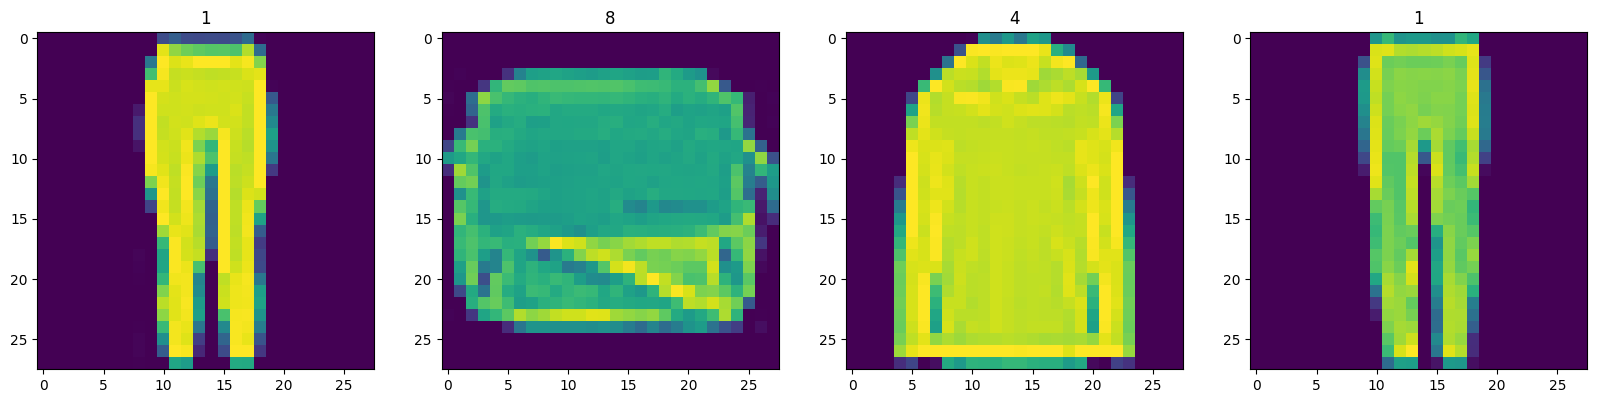

In [9]:
#setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample = dataiterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])

In [10]:
#scale and return images only
def scale_images(data):
    image = data['image']
    return image / 255

In [11]:
ds = tfds.load('fashion_mnist', split = 'train')
#running the dataset through the scale_image preprocessing step
ds = ds.map(scale_images)
#cache the dataset for that batch
ds = ds.cache()
#shuffle it up
ds = ds.shuffle(60000)
#batch into 128 images per sample
ds = ds.batch(128)
#reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [12]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

importing modelling components

In [13]:
#bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
#bring in the layers for the neural networks
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [14]:
def build_generator():
    model = Sequential()

    #takes in random values and reshpes it to 7x7x128
    #beginning of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    #upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

     #upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    #convulational block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

     #convulational block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    #sconv layer to get to one channel  
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [15]:
generator = build_generator()

In [16]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [17]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 198ms/step


In [18]:
img.shape

(4, 28, 28, 1)

1/1 [==============================] - 0s 33ms/step


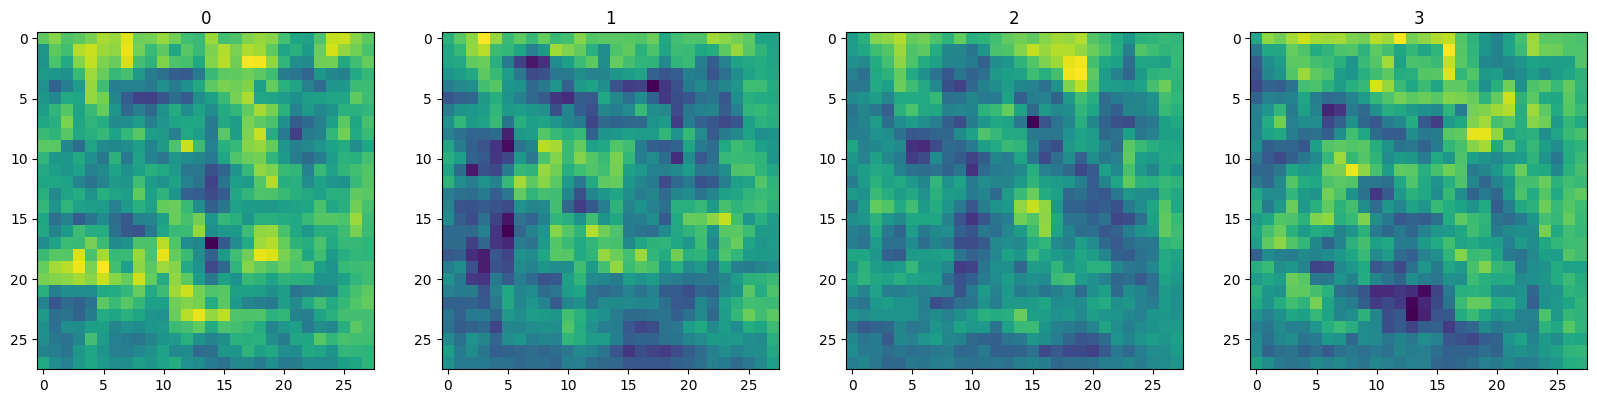

In [19]:
#generate new fashion
img = generator.predict(np.random.randn(4,128,1))
#setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
#copy four times and get the image
for idx, img in enumerate(img):
    #plot the img using specific subplot
    ax[idx].imshow(np.squeeze(img))
    #appending the image label as the plot title
    ax[idx].title.set_text(idx)

In [20]:
def build_discriminator():
    model = Sequential()

    #first conv block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #second conv block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

     #third conv block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

     #fourth conv block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #flatten then pass to Dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid')) 

    return model

In [21]:
discriminator = build_discriminator()

In [22]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [23]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 33ms/step


In [24]:
img = img[0]

In [25]:
img.shape

(28, 28, 1)

In [26]:
discriminator.predict(np.expand_dims(img,0))

1/1 [==============================] - 0s 74ms/step


array([[0.50031793]], dtype=float32)

setup losses and optimisers
as we have to train both generator and discriminator simaltaneously
so these will help in correcting the genrator and discriminator everytime the prediction goes wrong 


In [27]:
#adam will be optimiser for both  
from tensorflow.keras.optimizers import Adam
#BCe will gonna be loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [28]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [29]:
from tensorflow.keras.models import Model

In [30]:
tf.concat([tf.zeros_like(tf.random.normal((6, 128))), tf.ones_like(tf.random.normal((6, 128)))], axis=0)

<tf.Tensor: shape=(12, 128), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>

In [31]:
class FashGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
    #pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

    #Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        #compile with base class
        super().compile(*args, **kwargs)

        #create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        #get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128,128,1)), training=False)

        #train the discriminator
        with tf.GradientTape() as d_tape:
            #Pass the real and fake images to the discriminating model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            #create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            #add some noise to the true outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            #calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        #apply backpropogation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        #train the generator
        with tf.GradientTape() as g_tape:
            #generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
            
            #create the predictive labels
            predicted_labels= self.discriminator(gen_images, training=False)

            #calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        #apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [32]:
#create instance of subclassed 
fashgan = FashGAN(generator, discriminator)

In [33]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [34]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [35]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        if not os.path.exists('images'):
            os.makedirs('images')
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))


In [36]:
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
469/469 [==============================] - 1562s 3s/step - d_loss: 0.4283 - g_loss: 1.3201
Epoch 2/20
469/469 [==============================] - 1456s 3s/step - d_loss: 0.6001 - g_loss: 1.8333
Epoch 3/20
469/469 [==============================] - 1311s 3s/step - d_loss: 0.6326 - g_loss: 0.6538
Epoch 4/20
469/469 [==============================] - 5498s 12s/step - d_loss: 0.4868 - g_loss: 0.2829
Epoch 5/20
469/469 [==============================] - 1315s 3s/step - d_loss: 0.7264 - g_loss: 0.4470
Epoch 6/20
469/469 [==============================] - 1341s 3s/step - d_loss: 0.6982 - g_loss: 0.6179
Epoch 7/20
469/469 [==============================] - 1424s 3s/step - d_loss: 0.6958 - g_loss: 0.6265
Epoch 8/20
469/469 [==============================] - 14114s 30s/step - d_loss: 0.6882 - g_loss: 0.6368
Epoch 9/20
469/469 [==============================] - 1452s 3s/step - d_loss: 0.6956 - g_loss: 0.6219
Epoch 10/20
469/469 [==============================] - 1424s 3s/step - d_loss: 

In [1]:
plt.suptitle('loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

testing the generator


In [57]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 214ms/step


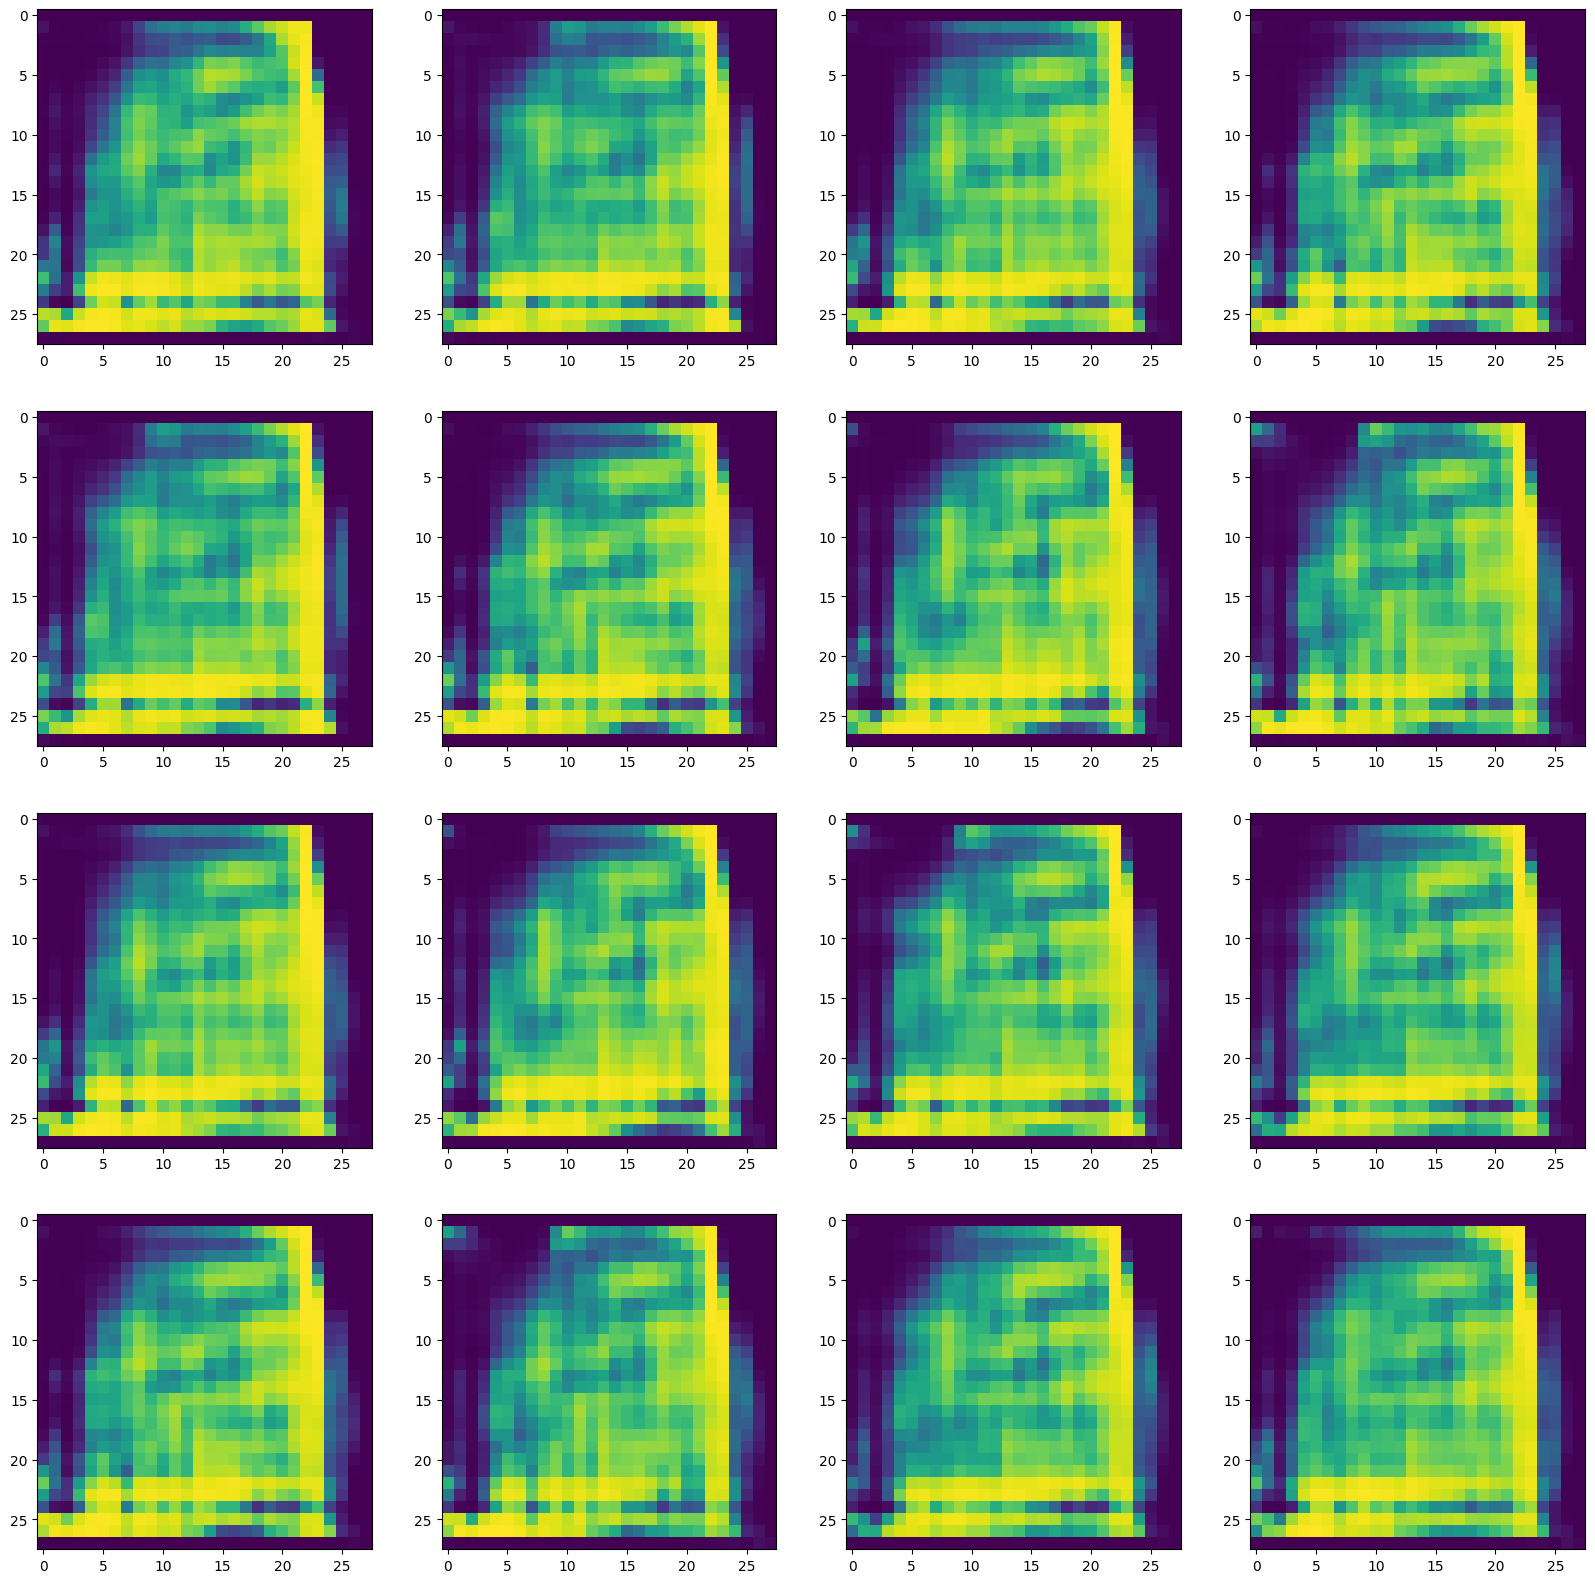

In [52]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')